# Import everything needed for MORO

In [2]:
SEED = 42 
import numpy.random
import random
numpy.random.seed(SEED)
random.seed(SEED)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools

In [3]:
from ema_workbench import (Model, RealParameter, Policy, Constant, Scenario, 
                           ScalarOutcome,MultiprocessingEvaluator, ema_logging, perform_experiments)
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.optimization import (EpsilonProgress, HyperVolume, ArchiveLogger)
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework import sample_uncertainties
from ema_workbench.em_framework.evaluators import BaseEvaluator

%matplotlib inline  
# With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, 
# directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

ema_logging.log_to_stderr(ema_logging.INFO)
dike_model, planning_steps = get_model_for_problem_formulation(1) # assign problem_formulation_id


C:\Users\georg\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [4]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''

'\nFor different list of outcomes:\n# 0 = 2-objective PF\n# 1 = 3-objective PF\n# 2 = 5-objective PF\n# 3 = Disaggregate over locations\n# 4 = Disaggregate over time\n# 5 = Fully disaggregated\n'

# Define the robustness metrics

In [5]:

# percentile90 = functools.partial(np.percentile, q=90)
# def var_mean(data):
#     return ((np.percentile(data,q=75)-np.percentile(data,q=25))*np.sum(data)/(data.shape[0]))

def mean_rob(data):
    return np.sum(data)/(data.shape[0]*1e9)

def threshold(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE 

SMALLER = "SMALLER"

death_funcs = functools.partial(threshold, SMALLER, 0.00001)
damage_funcs = functools.partial(threshold, SMALLER, 100000)

robustness_functions = [ScalarOutcome('Expected Number of Deaths', kind=MAXIMIZE,
                             variable_name='Expected Number of Deaths', function = death_funcs),
                        ScalarOutcome('Expected Annual Damage', kind=MAXIMIZE,
                             variable_name='Expected Annual Damage', function = damage_funcs),
                        ScalarOutcome('Total Investment Costs', kind=MINIMIZE,
                             variable_name='Total Investment Costs', function = mean_rob)]

In [6]:
# Expected Annual Damage
# RfR Investment Costs
# Evacuation Costs
# Expected Number of Deaths
# Total Investment Costs
scen = 100
pol = 15

# Check the number of needed scenarios

In [44]:
%%time 
from ema_workbench import ema_logging, MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=scen,               
                                            policies=pol)


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 15 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Wall time: 10min 25s


In [56]:
save_results(results, f"Outputs/perform_experiments/scen{scen}pol{pol}.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\Outputs\perform_experiments\scen100pol15.tar.gz


In [7]:
### other experiments perform_experiments400scen6pol.tar.gz
results = load_results(f"Outputs/perform_experiments/scen{scen}pol{pol}.tar.gz")
experiments, outcomes = results

TypeError: data type "category" not understood

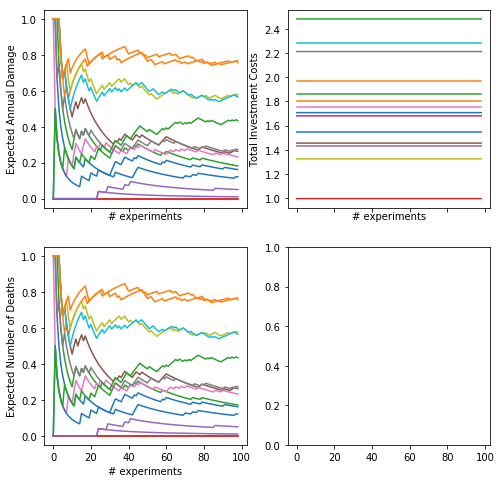

In [61]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]                             #axes[1,1]

SMALLER = 'SMALLER'
robustness_funcs = {"Expected Number of Deaths": functools.partial(threshold, SMALLER, 0.00001),
                    "Expected Annual Damage": functools.partial(threshold, SMALLER, 100000), 
                    "Total Investment Costs": mean_rob }


for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

In [65]:
# decision_varnames = list(dike_model.levers.keys())
# outcome_varnames = ["frac_{}".format(var_name) for var_name in dike_model.outcomes.keys()]
# outcome_varnames

In [10]:
n_scenarios = 10
scenarios = sample_uncertainties(dike_model, n_scenarios)

In [11]:
%%time
BaseEvaluator.reporting_frequency = 15

nfe = 400

epsilons = [0.05, 0.1, 0.05]

convergence_metrics = [HyperVolume(minimum=[0,0,0], maximum=[1.1, 3, 1.1]),
                       EpsilonProgress()]
 
with MultiprocessingEvaluator(dike_model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustness_functions, scenarios,
                            nfe=nfe, convergence=convergence_metrics, epsilons=epsilons)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/400 nfe
[MainProcess/INFO] optimization completed, found 7 solutions
[MainProcess/INFO] terminating pool


Wall time: 24min 52s


In [82]:
archive.to_csv(f"Outputs/robust_optimization/Archive{n_scenarios}scen{nfe}nfe")
convergence.to_csv(f"Outputs/robust_optimization/Convergence{n_scenarios}scen{nfe}nfe")

In [83]:
archive = pd.read_csv(f"Outputs/robust_optimization/Archive{n_scenarios}scen{nfe}nfe", index_col=0)
convergence = pd.read_csv(f"Outputs/robust_optimization/Convergence{n_scenarios}scen{nfe}nfe", index_col=0)

In [12]:
print(archive)

   0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0        0        0        1        0        0        0        0        0   
1        0        0        0        0        0        0        0        1   
2        0        0        0        1        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        1        0        0        0        1        1        1   
5        1        1        0        0        0        0        1        0   
6        0        0        0        1        0        0        0        0   

   2_RfR 2  3_RfR 0  ...  A.3_DikeIncrease 2  A.4_DikeIncrease 0  \
0        1        0  ...                   0                   2   
1        1        0  ...                   3                   9   
2        0        1  ...                   6                   9   
3        1        0  ...                   2                   0   
4        1        1  ...                   

In [13]:
convergence

hypervolume  epsilon_progress  nfe
0     0.000000                 0    0
1     0.000915                 7  100

## Convergence of ε and hypervolume

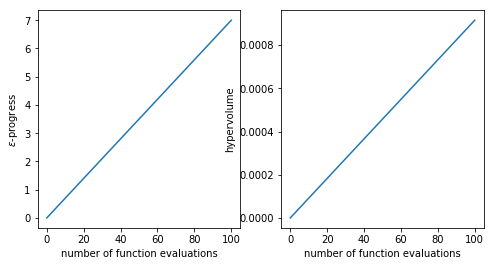

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()